In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os
import math
import numpy as np
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
from sklearn.model_selection import KFold

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1  # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 50  # 批大小，若用CPU，建议为1
input_length = 4  # 每个batch的输入数据长度，多步预测建议长，单步预测建议短
output_length = 1  # 每个batch的输出数据长度，1为单步预测，1以上为多步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.001  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 3  # lstm堆叠次数
dim = 512  # 隐层维度
interval_length = 55000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'mean_temp'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./london_weather.csv"
df = pd.read_csv(csv_path)

In [4]:
print(df.shape)

(15341, 10)


In [5]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [6]:
# checking null values in our dataset
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

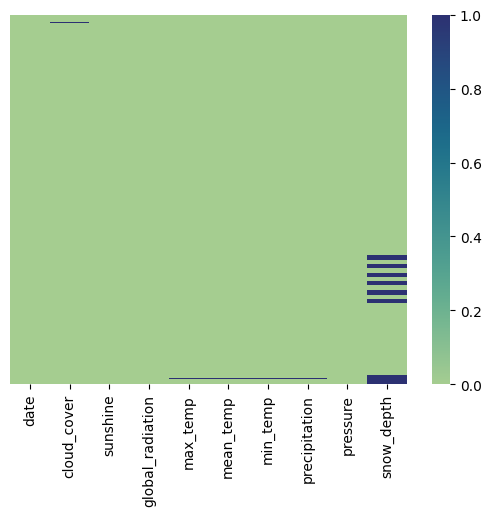

In [7]:
import seaborn as sns
sns.heatmap(df.isna(),yticklabels=False,cmap='crest')
plt.show()

In [8]:
df.drop('snow_depth',axis=1)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0
...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0


In [9]:
# 使用每一列的中位数填充缺失值
df = df.fillna(df.median())

In [10]:
# checking null values in our dataset
df.isna().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [11]:
df_1=df.copy()

In [12]:
# getting the datatypes of all the columns having null values
# first storing all the column names in a list having null values
col = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
df = df[col]
df[col].dtypes

cloud_cover         float64
sunshine            float64
global_radiation    float64
max_temp            float64
mean_temp           float64
min_temp            float64
precipitation       float64
pressure            float64
snow_depth          float64
dtype: object

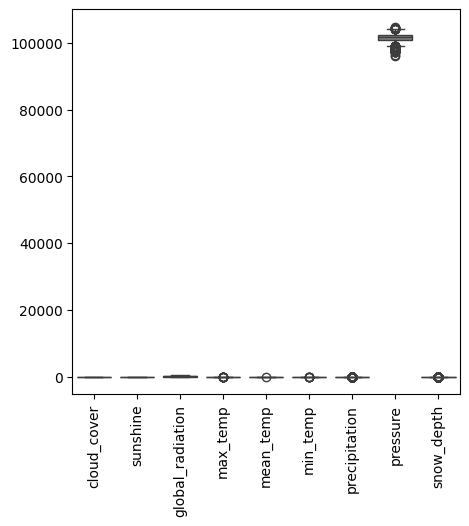

In [13]:
# plotting a boxplot
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

In [14]:
# getting the quartile one and quartile 3 values of each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
# finally calculating the interquartile range IQR
IQR = Q3 - Q1

In [15]:
# if the values fall behind Q1 - (1.5 * IQR) or above Q3 + 1.5*IQR,
#then it is been defined as outlier
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

cloud_cover            0
sunshine               0
global_radiation       0
max_temp              11
mean_temp              1
min_temp               5
precipitation       2105
pressure             243
snow_depth           140
dtype: int64

In [16]:
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
mask

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
15336,False,False,False,False,False,False,False,True,False
15337,False,False,False,False,False,False,False,True,False
15338,False,False,False,False,False,False,False,True,False
15339,False,False,False,False,False,False,False,False,False


In [17]:
for i in mask.columns:
    df[i].astype('float')
    temp = df[i].median()
    df.loc[mask[i], i] = temp

In [18]:
# outliers are now being handled and are replaced with that column's median value
((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

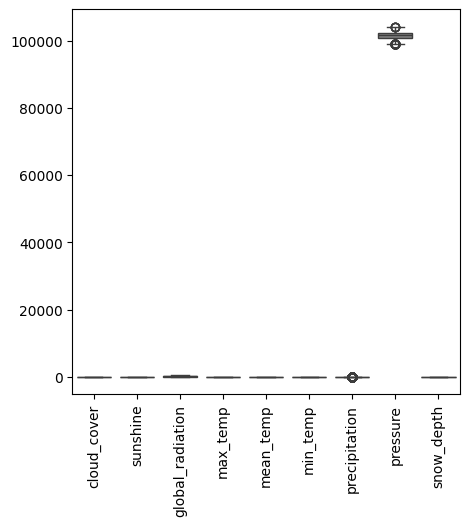

In [19]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

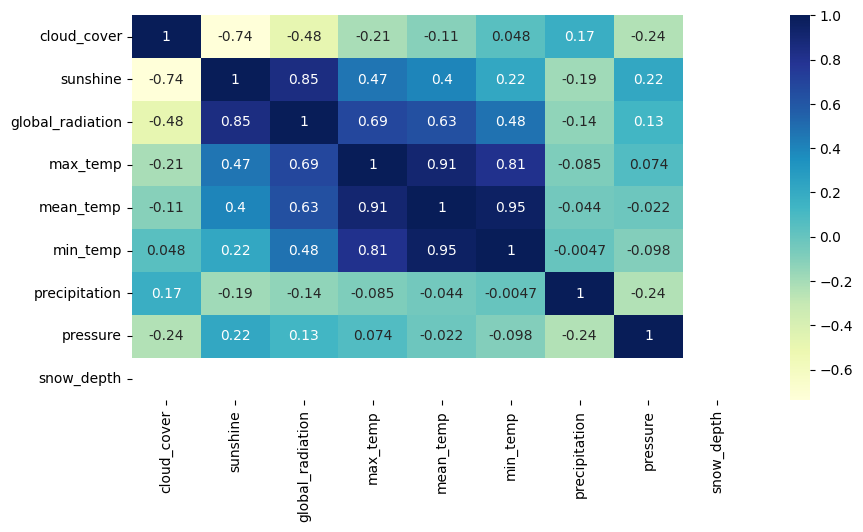

In [20]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [21]:
feature_keys = [
    'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure'
]

date_time_key = "date"

In [22]:
df = pd.concat([df_1['date'], df], axis=1)

In [23]:
# 删除多余的 'date' 列，保留第一个
df = df.loc[:, ~df.columns.duplicated()]

# 删除 'snow_depth' 列
df = df.drop(columns=['snow_depth'])

# 检查结果
print(df.head())


       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  
0      -7.5            0.4  101900.0  
1      -7.5            0.0  102530.0  
2      -7.2            0.0  102050.0  
3      -6.5            0.0  100840.0  
4      -1.4            0.0  102250.0  


In [24]:
features = df[feature_keys]
features.index = df[date_time_key]
features.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
date,,,,,,,,
19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0
19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0
19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0
19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0
19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0


In [25]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引


# 选择目标列和观察列
target = df['mean_temp']
observed_cov = df[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure']]

In [26]:
selected_columns = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure',
                   'mean_temp']

In [27]:
df_1=df[selected_columns]
df_1.head()

,cloud_cover,sunshine,global_radiation,max_temp,min_temp,precipitation,pressure,mean_temp
Date Time,,,,,,,,
1970-01-01 00:00:00.019790101,2.0,7.0,52.0,2.3,-7.5,0.4,101900.0,-4.1
1970-01-01 00:00:00.019790102,6.0,1.7,27.0,1.6,-7.5,0.0,102530.0,-2.6
1970-01-01 00:00:00.019790103,5.0,0.0,13.0,1.3,-7.2,0.0,102050.0,-2.8
1970-01-01 00:00:00.019790104,8.0,0.0,13.0,-0.3,-6.5,0.0,100840.0,-2.6
1970-01-01 00:00:00.019790105,6.0,2.0,29.0,5.6,-1.4,0.0,102250.0,-0.8


In [28]:
#  读取数据
df = df_1[:interval_length]
features_num = 8  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),\
                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [29]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 15337/15337 [00:04<00:00, 3194.80it/s]


In [30]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [31]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [32]:
# 定义 CNN-LSTM 模型
class CNN_LSTM_Attention(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Attention, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128,1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, n_vars, n_in] -> [batch, n_in, n_vars]
        x = self.conv1d(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # 调整为 [batch, 时间步, 通道数]
        lstm_out, _ = self.lstm1(x)
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out, _ = self.lstm2(attn_output)
        x = lstm_out[:, -1, :]  # 获取最后一个时间步的输出
        x = self.fc(x)
        return x

In [33]:
# 创建模型、损失函数和优化器
model = CNN_LSTM_Attention()
model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')

In [34]:
#  训练代数定义
epochs = 31
#  优化器定义，学习率衰减定义
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

In [35]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import r2_score

# Lists to store MAE, MSE, and R² for each epoch
train_mae_history = []
train_mse_history = []
train_r2_history = []
val_mae_history = []
val_mse_history = []
val_r2_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss_sum = 0
    train_mae_sum = 0
    train_mse_sum = 0
    all_train_preds = []
    all_train_labels = []
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()
        
        # Store predictions and labels for R² calculation
        all_train_preds.append(prediction.detach().cpu().numpy())
        all_train_labels.append(label_.detach().cpu().numpy())
        
        # Calculate MAE and MSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        mse = torch.mean((prediction - label_) ** 2).item()
        train_mae_sum += mae
        train_mse_sum += mse

    # Calculate R² for training data for the entire epoch
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    train_r2 = r2_score(all_train_labels, all_train_preds)
    
    # Record each epoch's metrics
    train_mae_history.append(train_mae_sum / (step + 1))  # Average MAE per epoch
    train_mse_history.append(train_mse_sum / (step + 1))  # Average MSE per epoch
    train_r2_history.append(train_r2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_sum:.4f}, Train MAE = {train_mae_history[-1]:.4f}, Train MSE = {train_mse_history[-1]:.4f}, Train R² = {train_r2:.4f}")

    # Validation
    model.eval()
    val_loss_sum = 0
    val_mae_sum = 0
    val_mse_sum = 0
    all_val_preds = []
    all_val_labels = []
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
        
        # Store predictions and labels for R² calculation
        all_val_preds.append(prediction.cpu().numpy())
        all_val_labels.append(label_.cpu().numpy())
        
        # Calculate MAE and MSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        mse = torch.mean((prediction - label_) ** 2).item()
        val_mae_sum += mae
        val_mse_sum += mse

    # Calculate R² for validation data for the entire epoch
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_r2 = r2_score(all_val_labels, all_val_preds)
    
    # Record each epoch's metrics
    val_mae_history.append(val_mae_sum / (val_step + 1))  # Average MAE per epoch
    val_mse_history.append(val_mse_sum / (val_step + 1))  # Average MSE per epoch
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch}: Val Loss = {val_loss_sum:.4f}, Val MAE = {val_mae_history[-1]:.4f}, Val MSE = {val_mse_history[-1]:.4f}, Val R² = {val_r2:.4f}")

    
    # Save best model
    if epoch == 0 or val_loss_sum < val_best:
        val_best = val_loss_sum
        #torch.save(model.state_dict(), './TCN_LSTM_KAN/TCN_LSTM_KAN_best')  # Save best weights
        print("val_best change")
    
    '''
    # Save model every 10 epochs
    if epoch % 10 == 0 and epoch >= 10:
        torch.save(model.state_dict(), f'./TCN_LSTM_KAN/TCN_LSTM_KAN_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")
    '''

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 0: Train Loss = 3.8970, Train MAE = 0.0930, Train MSE = 0.0158, Train R² = 0.3987
Epoch 0: Val Loss = 0.1843, Val MAE = 0.0620, Val MSE = 0.0059, Val R² = 0.7612
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 1: Train Loss = 1.9615, Train MAE = 0.0717, Train MSE = 0.0080, Train R² = 0.6991
Epoch 1: Val Loss = 0.2985, Val MAE = 0.0795, Val MSE = 0.0096, Val R² = 0.6134


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 2: Train Loss = 1.6605, Train MAE = 0.0657, Train MSE = 0.0068, Train R² = 0.7443
Epoch 2: Val Loss = 0.1439, Val MAE = 0.0547, Val MSE = 0.0046, Val R² = 0.8134
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 3: Train Loss = 1.4208, Train MAE = 0.0610, Train MSE = 0.0058, Train R² = 0.7810
Epoch 3: Val Loss = 0.1368, Val MAE = 0.0529, Val MSE = 0.0044, Val R² = 0.8239
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 4: Train Loss = 1.0912, Train MAE = 0.0529, Train MSE = 0.0044, Train R² = 0.8317
Epoch 4: Val Loss = 0.1140, Val MAE = 0.0483, Val MSE = 0.0037, Val R² = 0.8541
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 5: Train Loss = 1.0480, Train MAE = 0.0518, Train MSE = 0.0043, Train R² = 0.8386
Epoch 5: Val Loss = 0.1034, Val MAE = 0.0449, Val MSE = 0.0033, Val R² = 0.8691
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 6: Train Loss = 0.9662, Train MAE = 0.0499, Train MSE = 0.0039, Train R² = 0.8513
Epoch 6: Val Loss = 0.0996, Val MAE = 0.0438, Val MSE = 0.0032, Val R² = 0.8750
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 7: Train Loss = 0.8704, Train MAE = 0.0469, Train MSE = 0.0035, Train R² = 0.8658
Epoch 7: Val Loss = 0.0961, Val MAE = 0.0443, Val MSE = 0.0031, Val R² = 0.8752
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 8: Train Loss = 0.7651, Train MAE = 0.0440, Train MSE = 0.0031, Train R² = 0.8821
Epoch 8: Val Loss = 0.0816, Val MAE = 0.0407, Val MSE = 0.0026, Val R² = 0.8953
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 9: Train Loss = 0.7890, Train MAE = 0.0448, Train MSE = 0.0032, Train R² = 0.8784
Epoch 9: Val Loss = 0.0825, Val MAE = 0.0408, Val MSE = 0.0027, Val R² = 0.8942


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 10: Train Loss = 0.6861, Train MAE = 0.0418, Train MSE = 0.0028, Train R² = 0.8943
Epoch 10: Val Loss = 0.0806, Val MAE = 0.0404, Val MSE = 0.0026, Val R² = 0.8969
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 11: Train Loss = 0.6737, Train MAE = 0.0410, Train MSE = 0.0027, Train R² = 0.8962
Epoch 11: Val Loss = 0.0765, Val MAE = 0.0394, Val MSE = 0.0025, Val R² = 0.9014
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 12: Train Loss = 0.6476, Train MAE = 0.0403, Train MSE = 0.0026, Train R² = 0.9001
Epoch 12: Val Loss = 0.0751, Val MAE = 0.0392, Val MSE = 0.0024, Val R² = 0.9029
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 13: Train Loss = 0.7274, Train MAE = 0.0426, Train MSE = 0.0030, Train R² = 0.8877
Epoch 13: Val Loss = 0.0654, Val MAE = 0.0364, Val MSE = 0.0021, Val R² = 0.9153
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 14: Train Loss = 0.6107, Train MAE = 0.0391, Train MSE = 0.0025, Train R² = 0.9057
Epoch 14: Val Loss = 0.0688, Val MAE = 0.0371, Val MSE = 0.0022, Val R² = 0.9109


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 15: Train Loss = 0.5837, Train MAE = 0.0382, Train MSE = 0.0024, Train R² = 0.9099
Epoch 15: Val Loss = 0.0653, Val MAE = 0.0360, Val MSE = 0.0021, Val R² = 0.9153
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 16: Train Loss = 0.5942, Train MAE = 0.0386, Train MSE = 0.0024, Train R² = 0.9083
Epoch 16: Val Loss = 0.0607, Val MAE = 0.0351, Val MSE = 0.0020, Val R² = 0.9215
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 17: Train Loss = 0.5252, Train MAE = 0.0362, Train MSE = 0.0021, Train R² = 0.9189
Epoch 17: Val Loss = 0.0646, Val MAE = 0.0358, Val MSE = 0.0021, Val R² = 0.9162


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 18: Train Loss = 0.4985, Train MAE = 0.0351, Train MSE = 0.0020, Train R² = 0.9231
Epoch 18: Val Loss = 0.0622, Val MAE = 0.0351, Val MSE = 0.0020, Val R² = 0.9193


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 19: Train Loss = 0.5376, Train MAE = 0.0361, Train MSE = 0.0022, Train R² = 0.9172
Epoch 19: Val Loss = 0.0553, Val MAE = 0.0334, Val MSE = 0.0018, Val R² = 0.9282
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 20: Train Loss = 0.5431, Train MAE = 0.0363, Train MSE = 0.0022, Train R² = 0.9163
Epoch 20: Val Loss = 0.0534, Val MAE = 0.0329, Val MSE = 0.0017, Val R² = 0.9307
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 21: Train Loss = 0.5623, Train MAE = 0.0374, Train MSE = 0.0023, Train R² = 0.9133
Epoch 21: Val Loss = 0.0541, Val MAE = 0.0326, Val MSE = 0.0017, Val R² = 0.9298


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 22: Train Loss = 0.5422, Train MAE = 0.0368, Train MSE = 0.0022, Train R² = 0.9164
Epoch 22: Val Loss = 0.0727, Val MAE = 0.0381, Val MSE = 0.0023, Val R² = 0.9056


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 23: Train Loss = 0.4970, Train MAE = 0.0352, Train MSE = 0.0020, Train R² = 0.9233
Epoch 23: Val Loss = 0.0626, Val MAE = 0.0355, Val MSE = 0.0020, Val R² = 0.9187


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 24: Train Loss = 0.5253, Train MAE = 0.0362, Train MSE = 0.0021, Train R² = 0.9189
Epoch 24: Val Loss = 0.0583, Val MAE = 0.0337, Val MSE = 0.0019, Val R² = 0.9243


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 25: Train Loss = 0.4766, Train MAE = 0.0338, Train MSE = 0.0019, Train R² = 0.9264
Epoch 25: Val Loss = 0.0535, Val MAE = 0.0323, Val MSE = 0.0017, Val R² = 0.9306


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 26: Train Loss = 0.4615, Train MAE = 0.0334, Train MSE = 0.0019, Train R² = 0.9289
Epoch 26: Val Loss = 0.0488, Val MAE = 0.0311, Val MSE = 0.0016, Val R² = 0.9366
val_best change


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 27: Train Loss = 0.3989, Train MAE = 0.0313, Train MSE = 0.0016, Train R² = 0.9385
Epoch 27: Val Loss = 0.0527, Val MAE = 0.0325, Val MSE = 0.0017, Val R² = 0.9316


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 28: Train Loss = 0.4441, Train MAE = 0.0329, Train MSE = 0.0018, Train R² = 0.9315
Epoch 28: Val Loss = 0.0536, Val MAE = 0.0328, Val MSE = 0.0017, Val R² = 0.9305


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 29: Train Loss = 0.4262, Train MAE = 0.0325, Train MSE = 0.0017, Train R² = 0.9343
Epoch 29: Val Loss = 0.0549, Val MAE = 0.0333, Val MSE = 0.0018, Val R² = 0.9287


/tmp/ipykernel_15198/3330982320.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 30: Train Loss = 0.4179, Train MAE = 0.0319, Train MSE = 0.0017, Train R² = 0.9357
Epoch 30: Val Loss = 0.0678, Val MAE = 0.0362, Val MSE = 0.0022, Val R² = 0.9119
best val loss = 0.04881460900651291
——————————————————————Training Ends——————————————————————


In [36]:
np.savez('./CNN_LSTM_metrics_history_2.npz', 
         train_mae=train_mae_history, 
         train_mse=train_mse_history, 
         train_r2=train_r2_history, 
         val_mae=val_mae_history, 
         val_mse=val_mse_history, 
         val_r2=val_r2_history)


In [ ]:
# 设置 epoch 从 101 开始
start_epoch = 101

# 加载第100个 epoch 保存的模型权重
model.load_state_dict(torch.load('./CNN_LSTM_Attention_0001/cnn_lstm_epoch_100.pth'))
print(f"Model loaded from epoch 100, continuing training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)

for epoch in range(start_epoch, epochs + 1):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)
    
    print(f"epoch = {epoch}")
    print(f'train_loss = {train_loss_sum}')

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print(f'val_loss = {val_loss_sum}')
    if epoch == start_epoch:  # 第101个 epoch
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './CNN_LSTM_Attention_0001/cnn_lstm_best')  # 保存最好权重
            print("val_best changed")

    # 每隔一个 epoch 保存一次模型
    if epoch % 1 == 0:
        torch.save(model.state_dict(), f'./CNN_LSTM_Attention_0001/cnn_lstm_epoch_{epoch}.pth')  # 保存模型
        print(f"Model saved at epoch {epoch}")

print(f"best val loss = {val_best}")
print("——————————————————————Training Ends——————————————————————")

# 绘制损失曲线
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

Model loaded from epoch 100, continuing training from epoch 101
——————————————————————Training Starts——————————————————————


/tmp/ipykernel_11960/2295505794.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


epoch = 101
train_loss = 0.27763056693947874
val_loss = 0.039354843203909695
Model saved at epoch 101


In [38]:
# 训练及验证循环
train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0,2,1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)
    
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print('val_loss = ' + str(val_loss_sum))
    if epoch == 0:
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './CNN_LSTM_Attention_0001/cnn_lstm_best')  # 保存最好权重
            print("val_best change")
    
    # 每隔一个epoch保存一次模型, 从第10个epoch开始
    if epoch >= 10 and epoch % 1 == 0:
        torch.save(model.state_dict(), f'./CNN_LSTM_Attention_0001/cnn_lstm_epoch_{epoch}.pth')  # 保存模型
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

# 绘制损失曲线
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_11344/3874496585.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


epochs = 0
train_loss = 4.707814124412835
val_loss = 0.1759637164650485
epochs = 1
train_loss = 1.8144885902293026
val_loss = 0.1790044178487733
epochs = 2
train_loss = 1.5322746390011162
val_loss = 0.14216559124179184
val_best change
epochs = 3
train_loss = 1.2455927754053846
val_loss = 0.15943701833020896
epochs = 4
train_loss = 1.1623648474924266
val_loss = 0.139776382711716
val_best change
epochs = 5
train_loss = 1.113149695447646
val_loss = 0.1423188445623964
epochs = 6
train_loss = 1.0535725769586861
val_loss = 0.1030884167412296
val_best change
epochs = 7
train_loss = 0.9241603987757117
val_loss = 0.10284433513879776
val_best change
epochs = 8
train_loss = 0.8340896447189152
val_loss = 0.09184976434335113
val_best change
epochs = 9
train_loss = 0.703878580359742
val_loss = 0.08686709112953395
val_best change
epochs = 10
train_loss = 0.6748398364870809
val_loss = 0.08503307361388579
val_best change
Model saved at epoch 10
epochs = 11
train_loss = 0.7070510336197913
val_loss = 0.0

KeyboardInterrupt: 

In [63]:
#  测试集预测
model.load_state_dict(torch.load('./CNN_LSTM_Attention_0001/cnn_lstm_best'))  # 调用权重
test_loss_sum = 0
step = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Testing Starts——————————————————————
test loss = 0.06938394322060049
——————————————————————Testing Ends——————————————————————


——————————————————————Post-Processing——————————————————————


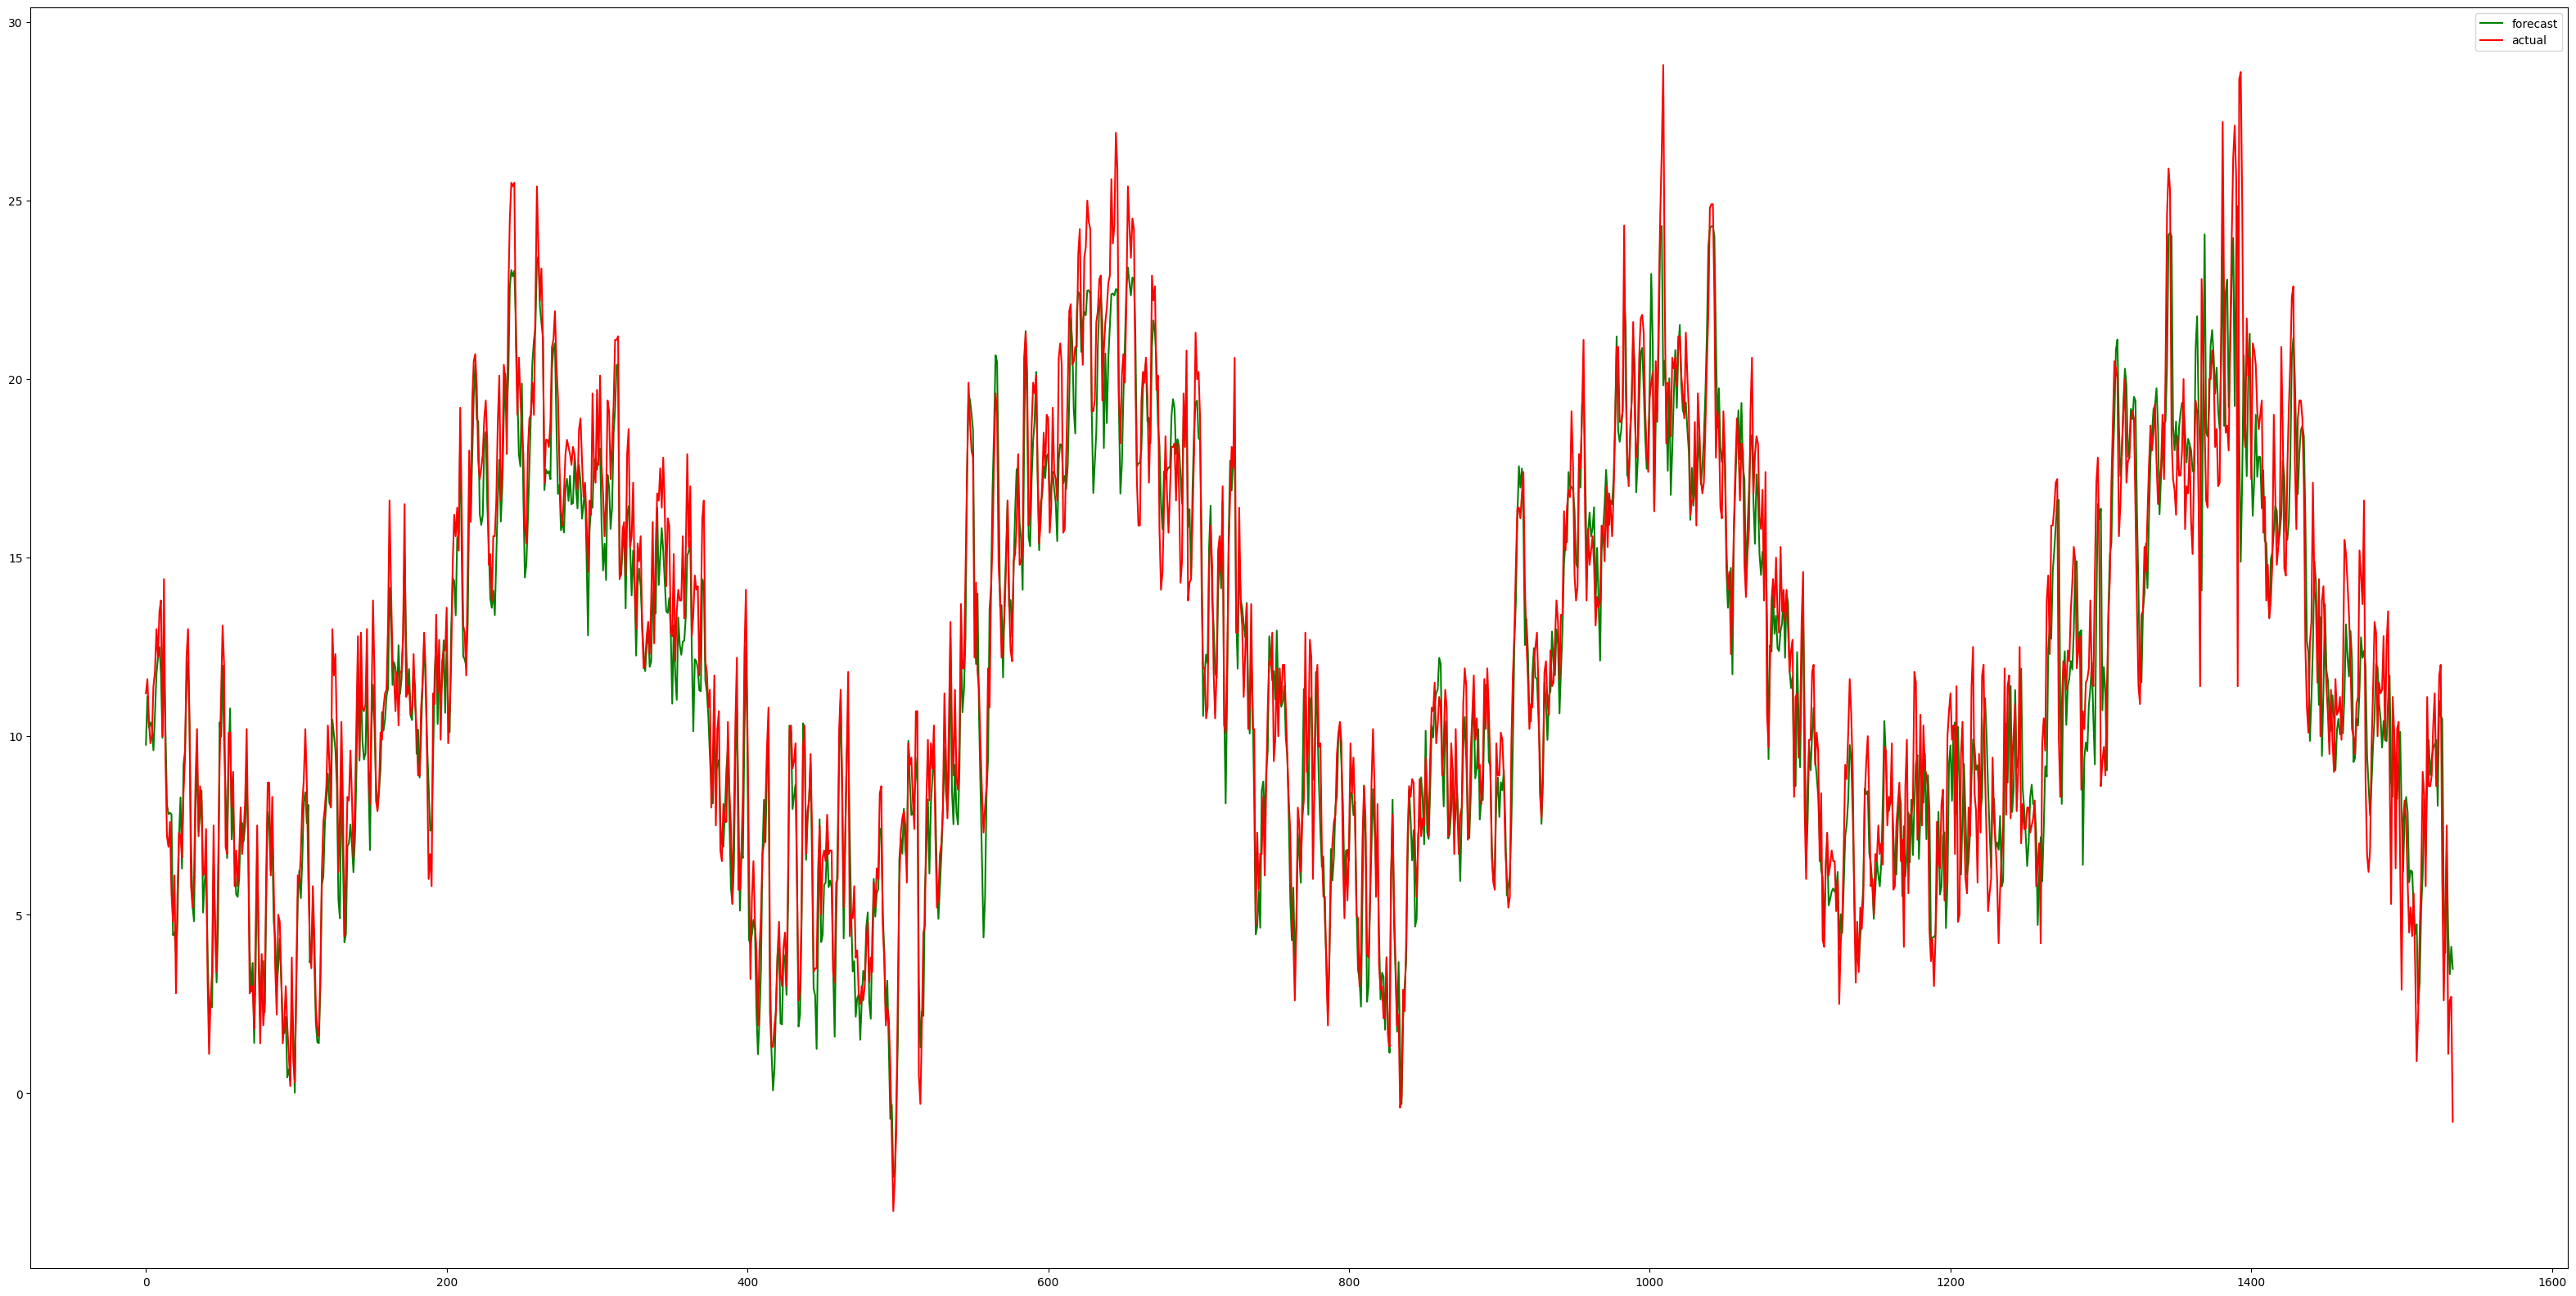

MSE loss=2.7607258389568803
MAE loss=1.2202819132571887
MAPE loss=0.1443561726511964
R2=0.9167710988467118


In [64]:
# 数据后处理，单步预测绘制全部预测值的图像，多步预测仅绘制第一个batch的输出图像
#  逆归一化过程及绘制图像
print("——————————————————————Post-Processing——————————————————————")
#test_labels = torch.tensor(test_labels)

if scalar_contain_labels and scalar :
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num>1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1),torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    #  计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)